# kmeans

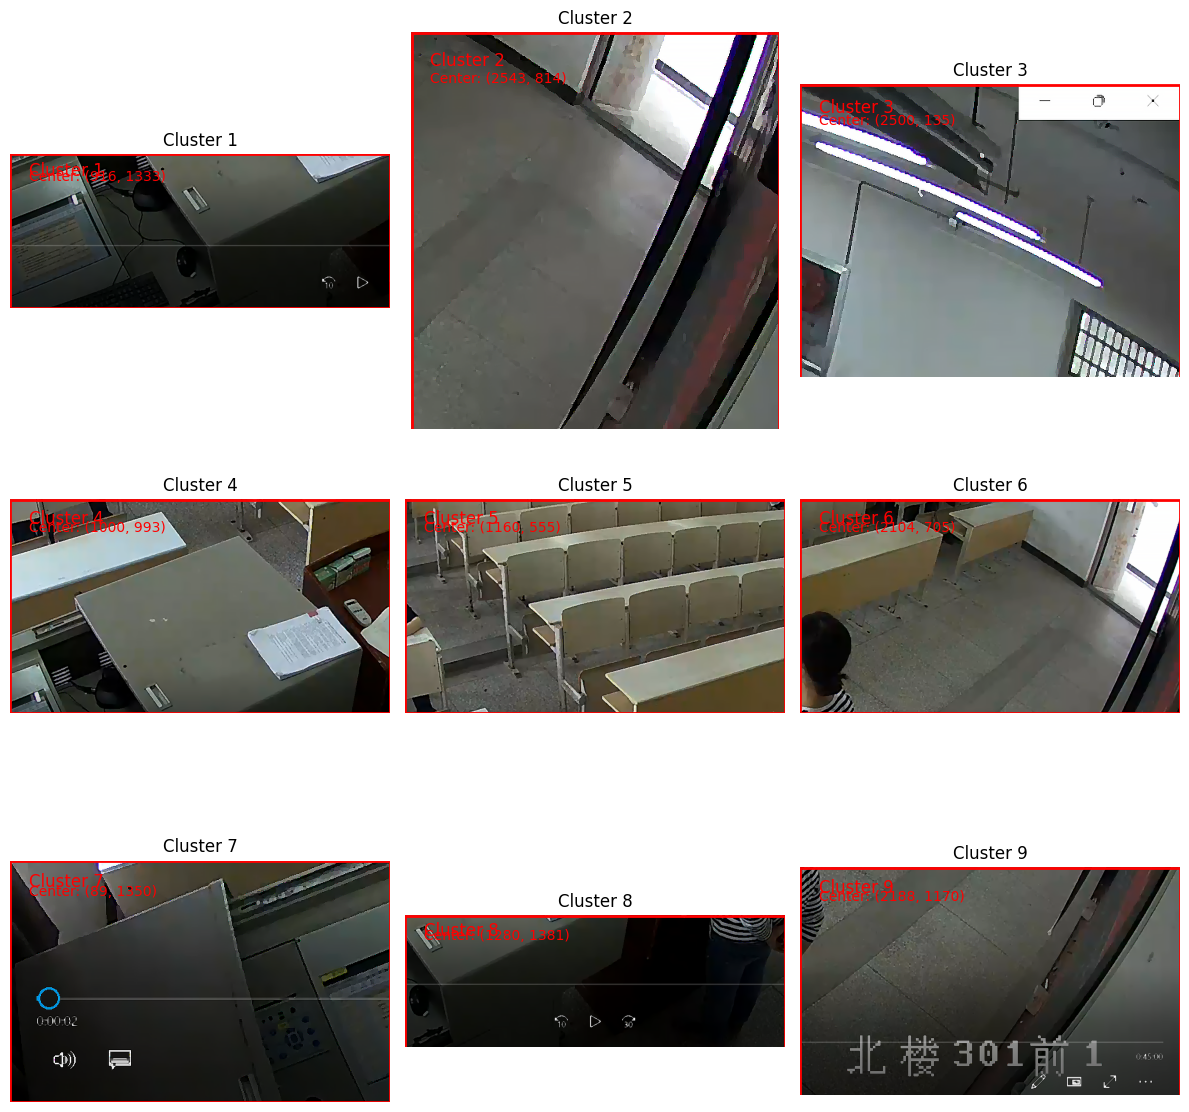

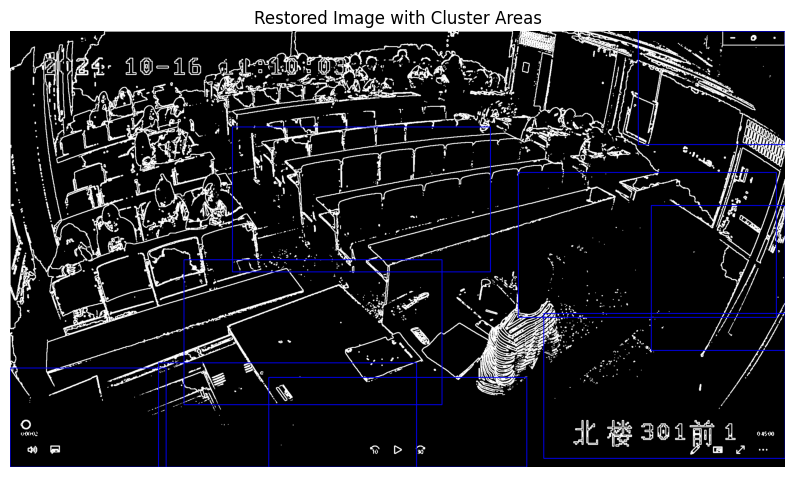

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matplotlib.patches import Rectangle

# 设定图像的聚类行列数
row = 3
col = 3

# 读取图像
image_ori = cv2.imread(r'C:\Users\rainbow_yu\Desktop\test.png', cv2.IMREAD_COLOR)
image_ori = cv2.cvtColor(image_ori, cv2.COLOR_BGR2RGB)
image = cv2.cvtColor(image_ori, cv2.COLOR_BGR2GRAY)
height, width = image.shape

# 采用二值化方式处理图像。
ret, thresh=cv2.threshold(image, 120, 255, 0)
_,white_img =cv2.threshold(image, 0, 0, 0)

#使用简易方式英取全部轮廓
contours, hierarchy= cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

img_count = cv2.drawContours(white_img, contours, -1, (255,255,255), 2)

# 执行膨胀操作以扩大连通区域
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 50))  # 核大小越大，扩展范围越大
dilated_image = cv2.dilate(img_count, kernel, iterations=1)

# 去除小噪点：使用开运算（先腐蚀后膨胀）来去除小的连通区域
kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))  # 可调整核的大小
opened_image = cv2.morphologyEx(dilated_image, cv2.MORPH_OPEN, kernel_open)

# 查找连通域
contours, _ = cv2.findContours(opened_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

init_centroids = []
for i in range(row):
    for j in range(col):
        cX = int((j + 0.5) * (width / col))  # 水平等分点
        cY = int((i + 0.5) * (height / row))  # 垂直等分点
        init_centroids.append([cX, cY])

init_centroids = np.array(init_centroids)

# 获取连通域的中心坐标
centroids = []
for contour in contours:
    M = cv2.moments(contour)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centroids.append([cX, cY])

# 使用 KMeans 聚类算法对中心点进行聚类
num_classes = row * col  # 设置你希望的聚类数目
kmeans = KMeans(n_clusters=num_classes, init=init_centroids, n_init=1)
kmeans.fit(centroids)

# 获取图像的尺寸
height, width = image.shape

# 根据聚类中心分配图像区域
cluster_centers = kmeans.cluster_centers_

# 创建子图
fig, axes = plt.subplots(row, col, figsize=(12, 12))  # 创建2x2的子图
axes = axes.flatten()  # 将axes展平成一维，便于索引

# 创建一张新的图像，用于显示聚类区域
restored_image = cv2.cvtColor(img_count.copy(), cv2.COLOR_GRAY2RGB)

# 遍历每个聚类并进行分配显示
for idx, ax in enumerate(axes):
    ax.set_title(f'Cluster {idx + 1}')
    ax.axis('off')

    # 获取当前聚类的中心
    center = cluster_centers[idx]
    cX, cY = int(center[0]), int(center[1])

    # 计算子图区域的边界，给定中心和一些大小
    sub_width = width // col
    sub_height = height // row

    # 计算聚类边界（基于中心点的偏移）
    start_y = max(0, cY - sub_height // 2)
    end_y = min(height, cY + sub_height // 2)
    start_x = max(0, cX - sub_width // 2)
    end_x = min(width, cX + sub_width // 2)

    # 切割原始图像的对应部分
    sub_image = image_ori[start_y:end_y, start_x:end_x]

    # 显示切割的子图
    ax.imshow(sub_image)

    # 在子图外面画一个矩形框，框住该区域
    rect = Rectangle((0, 0), end_x - start_x, end_y - start_y, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

    # 绘制聚类信息：显示聚类编号和中心坐标
    ax.text(0.05, 0.95, f'Cluster {idx + 1}', transform=ax.transAxes, color='red', fontsize=12, ha='left', va='top')
    ax.text(0.05, 0.90, f'Center: ({cX}, {cY})', transform=ax.transAxes, color='red', fontsize=10, ha='left', va='top')

    # 在原图上绘制矩形框，标出当前子图区域
    cv2.rectangle(restored_image, (start_x, start_y), (end_x, end_y), (0, 0, 255), 2)

# 显示聚类信息的图像
plt.tight_layout()
plt.show()

# 显示原图像及其聚类区域
plt.figure(figsize=(10, 10))
plt.imshow(restored_image, cmap='gray')
plt.title("Restored Image with Cluster Areas")
plt.axis('off')
plt.show()


# dbscan

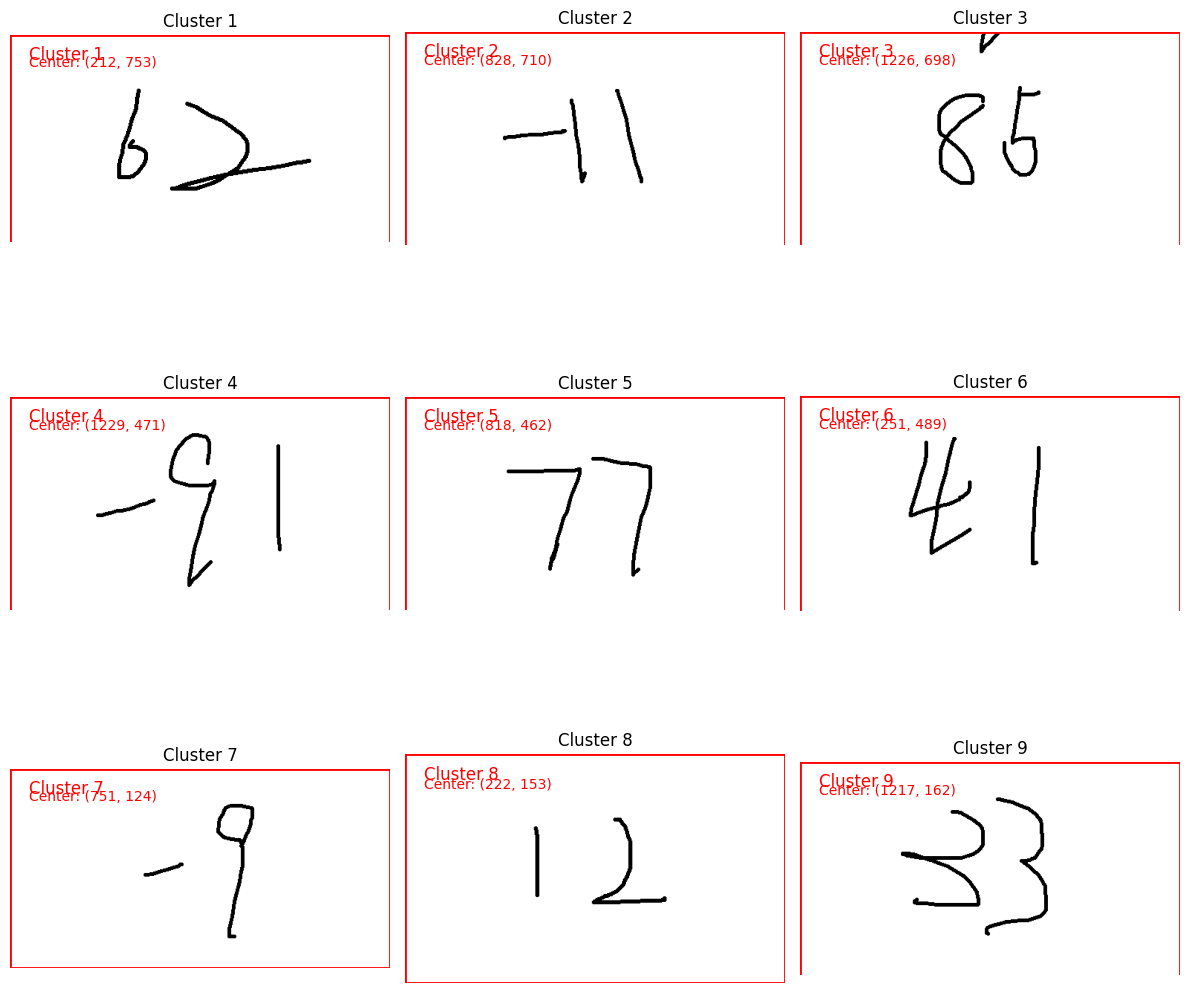

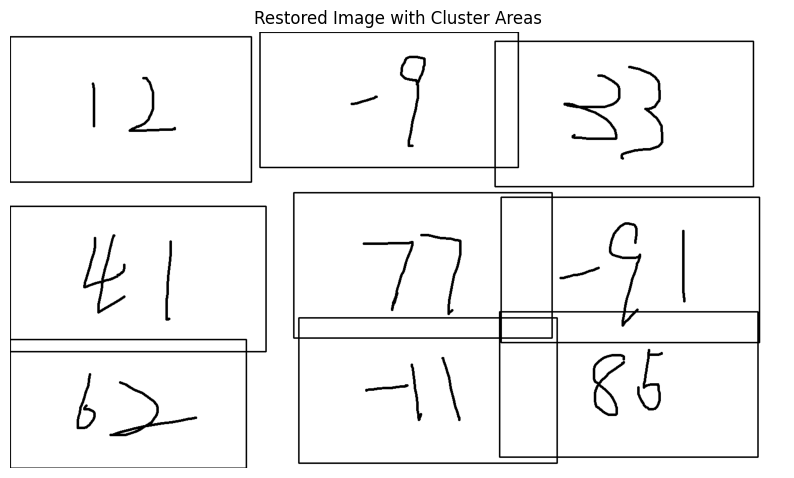

In [44]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from matplotlib.patches import Rectangle

# 读取图像
image = cv2.imread(r'C:\Users\rainbow_yu\Desktop\t2.png', cv2.IMREAD_GRAYSCALE)

# 二值化（将图像转为黑白）
_, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)

# 执行膨胀操作以扩大连通区域
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))  # 核大小越大，扩展范围越大
dilated_image = cv2.dilate(binary_image, kernel, iterations=1)

# 去除小噪点：使用开运算（先腐蚀后膨胀）来去除小的连通区域
kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))  # 可调整核的大小
opened_image = cv2.morphologyEx(dilated_image, cv2.MORPH_OPEN, kernel_open)

# 查找连通域
contours, _ = cv2.findContours(opened_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 获取连通域的中心坐标
centroids = []
for contour in contours:
    M = cv2.moments(contour)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centroids.append([cX, cY])

# 使用 DBSCAN 聚类算法进行聚类
eps = 150  # 邻域半径
min_samples = 1  # 每个聚类中的最小样本数
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(centroids)

# 获取图像的尺寸
height, width = image.shape

# 获取聚类结果
unique_labels = np.unique(labels)

# 计算聚类数目（排除噪声点标签为-1）
num_clusters = len(unique_labels[unique_labels != -1])

# 根据聚类数目计算行列数（例如，行列数尽量接近）
row = int(np.ceil(np.sqrt(num_clusters)))
col = int(np.ceil(num_clusters / row))

# 创建子图
fig, axes = plt.subplots(row, col, figsize=(12, 12))  # 创建动态行列数的子图
axes = axes.flatten()  # 将axes展平成一维，便于索引

# 创建一张新的图像，用于显示聚类区域
restored_image = image.copy()

# 遍历每个聚类并进行分配显示
for idx, ax in enumerate(axes):
    ax.set_title(f'Cluster {idx + 1}')
    ax.axis('off')

    # 获取当前聚类的中心
    if idx < len(unique_labels) and unique_labels[idx] != -1:  # 排除噪声点（标签为-1）
        cluster_label = unique_labels[idx]
        cluster_centroids = [centroids[i] for i in range(len(centroids)) if labels[i] == cluster_label]

        # 计算聚类的中心点
        center = np.mean(cluster_centroids, axis=0)
        cX, cY = int(center[0]), int(center[1])

        # 计算子图区域的边界，给定中心和一些大小
        sub_width = width // col
        sub_height = height // row

        # 计算聚类边界（基于中心点的偏移）
        start_y = max(0, cY - sub_height // 2)
        end_y = min(height, cY + sub_height // 2)
        start_x = max(0, cX - sub_width // 2)
        end_x = min(width, cX + sub_width // 2)

        # 切割原始图像的对应部分
        sub_image = image[start_y:end_y, start_x:end_x]

        # 显示切割的子图
        ax.imshow(sub_image, cmap='gray')

        # 在子图外面画一个矩形框，框住该区域
        rect = Rectangle((0, 0), end_x - start_x, end_y - start_y, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

        # 绘制聚类信息：显示聚类编号和中心坐标
        ax.text(0.05, 0.95, f'Cluster {idx + 1}', transform=ax.transAxes, color='red', fontsize=12, ha='left', va='top')
        ax.text(0.05, 0.90, f'Center: ({cX}, {cY})', transform=ax.transAxes, color='red', fontsize=10, ha='left', va='top')

        # 在原图上绘制矩形框，标出当前子图区域
        cv2.rectangle(restored_image, (start_x, start_y), (end_x, end_y), (0, 0, 0), 2)

# 显示聚类信息的图像
plt.tight_layout()
plt.show()

# 显示原图像及其聚类区域
plt.figure(figsize=(10, 10))
plt.imshow(restored_image, cmap='gray')
plt.title("Restored Image with Cluster Areas")
plt.axis('off')
plt.show()



0: 288x640 1 2, 16.1ms
Speed: 8.8ms preprocess, 16.1ms inference, 31.2ms postprocess per image at shape (1, 3, 288, 640)
Detection 0: [     317.51      44.388       428.3      157.11]

0: 288x640 1 -, 7.2ms
Speed: 1.0ms preprocess, 7.2ms inference, 2.0ms postprocess per image at shape (1, 3, 288, 640)
Detection 0: [     82.898      56.045      157.53      127.72]

0: 320x640 (no detections), 13.0ms
Speed: 1.0ms preprocess, 13.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)
No detections found.

0: 384x640 (no detections), 10.6ms
Speed: 1.0ms preprocess, 10.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
No detections found.

0: 288x640 1 ], 11.7ms
Speed: 1.0ms preprocess, 11.7ms inference, 3.0ms postprocess per image at shape (1, 3, 288, 640)
Detection 0: [     488.72      17.495      511.98      211.79]

0: 288x640 (no detections), 7.6ms
Speed: 1.0ms preprocess, 7.6ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)
No detecti

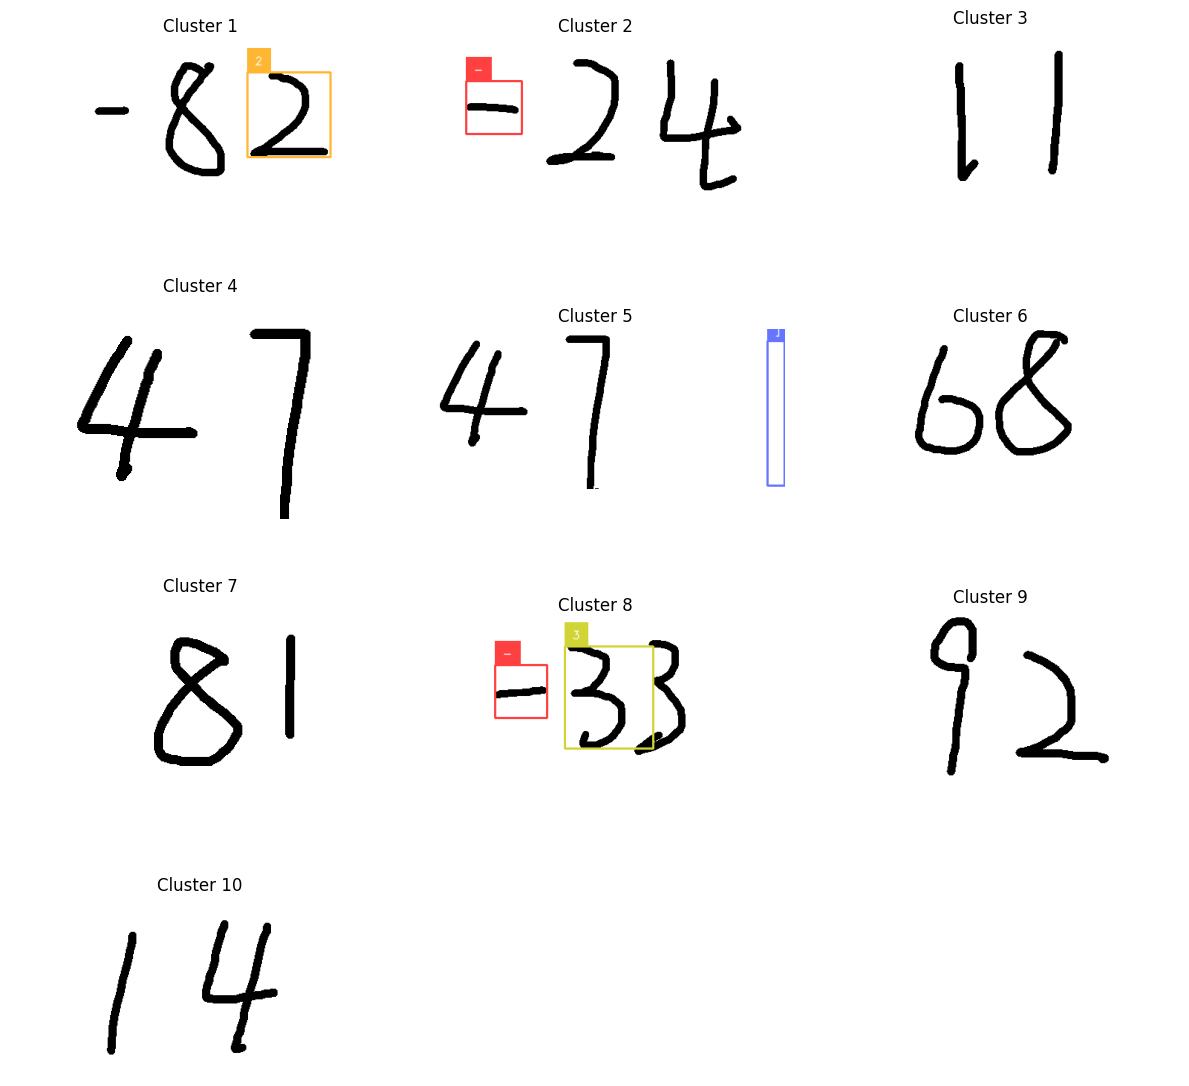

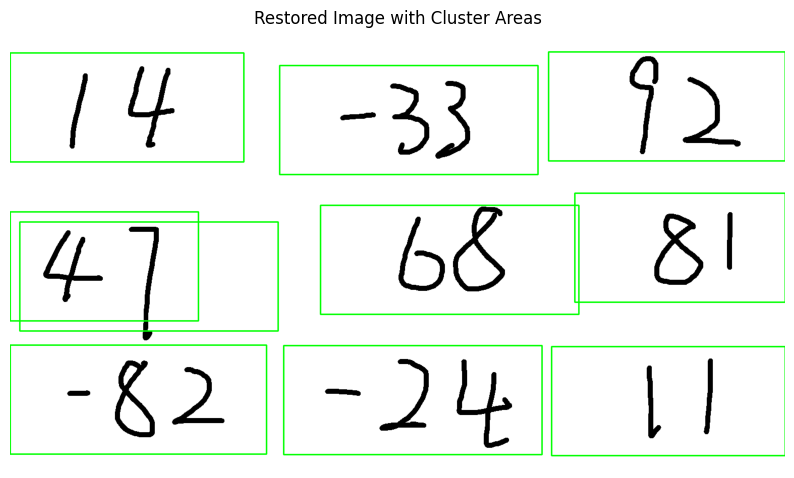

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from ultralytics import YOLO
import supervision as sv

# 初始化监督库的注解器
bounding_box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

# Load YOLO model (adjust the model path as needed)
model = YOLO(r"E:\ipynb\pyhton_design\models\v3.5\weights\best.pt")

def detect_objects_in_subimage(image):
    # Convert to BGR if needed
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    results = model(image)[0]
    detections = sv.Detections.from_ultralytics(results)

    # 打印检测框坐标
    if detections.xyxy.size > 0:
        for i, box in enumerate(detections.xyxy):
            print(f"Detection {i}: {box}")
    else:
        print("No detections found.")

    # 注解图像
    annotated_image = bounding_box_annotator.annotate(scene=image, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)
    return annotated_image

# 读取图像
image = cv2.imread(r'C:\Users\rainbow_yu\Desktop\t4.png', cv2.IMREAD_GRAYSCALE)

# 二值化
_, binary_image = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY_INV)

# 膨胀操作
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))
dilated_image = cv2.dilate(binary_image, kernel, iterations=1)

# 去除小噪点
kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
opened_image = cv2.morphologyEx(dilated_image, cv2.MORPH_OPEN, kernel_open)

# 查找连通域
contours, _ = cv2.findContours(opened_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 获取连通域的中心坐标
centroids = []
for contour in contours:
    M = cv2.moments(contour)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centroids.append([cX, cY])

# 使用 DBSCAN 聚类
eps = 150
min_samples = 1
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(centroids)

# 获取图像尺寸
height, width = image.shape
unique_labels = np.unique(labels)
num_clusters = len(unique_labels[unique_labels != -1])

# 计算子图行列数
row = int(np.ceil(np.sqrt(num_clusters)))
col = int(np.ceil(num_clusters / row))

# 创建子图
fig, axes = plt.subplots(row, col, figsize=(12, 12))
axes = axes.flatten()

# 创建新的图像用于显示聚类区域
restored_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# 遍历每个聚类
for idx, ax in enumerate(axes):
    ax.axis('off')

    if idx >= len(unique_labels) or unique_labels[idx] == -1:
        ax.set_visible(False)  # 隐藏多余的子图
        continue

    cluster_label = unique_labels[idx]
    cluster_centroids = [centroids[i] for i in range(len(centroids)) if labels[i] == cluster_label]

    # 聚类中心
    center = np.mean(cluster_centroids, axis=0)
    cX, cY = int(center[0]), int(center[1])

    # 聚类区域
    sub_width = width // col
    sub_height = height // row
    start_y = max(0, cY - sub_height // 2)
    end_y = min(height, cY + sub_height // 2)
    start_x = max(0, cX - sub_width // 2)
    end_x = min(width, cX + sub_width // 2)

    # 子图切割
    sub_image = image[start_y:end_y, start_x:end_x]

    # Apply YOLO object detection
    annotated_sub_image = detect_objects_in_subimage(sub_image)

    # 显示子图
    ax.imshow(cv2.cvtColor(annotated_sub_image, cv2.COLOR_BGR2RGB))
    ax.set_title(f'Cluster {idx + 1}')

    # 原图绘制矩形框
    cv2.rectangle(restored_image, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)

# 显示子图
plt.tight_layout()
plt.show()

# 显示聚类区域的原图
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(restored_image, cv2.COLOR_BGR2RGB))
plt.title("Restored Image with Cluster Areas")
plt.axis('off')
plt.show()
